In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from tensorflow.keras.models import Model, load_model

In [3]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dense, Dropout, Activation,
                                     Flatten, GlobalAveragePooling2D)
import tensorflow as tf

In [4]:
data_path ="./train"
x_data_list = []
y_data_list = []
for roots, dirs, files in os.walk(data_path):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list.append(os.path.join(roots.split("/")[-1], each))
            y_data_list.append(roots.split("/")[-1])

In [5]:
data_path_test = "./testset"
x_data_list_test = []
y_data_list_test = []
for roots, dirs, files in os.walk(data_path_test):
    for each in files:
        if each.find('checkpoint') == -1:
            x_data_list_test.append(os.path.join(roots.split("/")[-1], each))

In [6]:
last_test2=[]
for i in x_data_list_test:
        spl = i.split("/",1)[1]
        last_test2.append(spl)

In [7]:
x_data_filename = []
for i in x_data_list_test:
    spl = i.split(".",1)[0]
    x_data_filename.append(spl)

In [8]:
x_data_filename2 = []
for i in x_data_list_test:
    spl = i.split("/",1)[1]
    x_data_filename2.append(spl)

In [9]:
class_map = pd.read_csv(os.path.join('./mapping.txt'),
                        header=None, index_col=0)
class_map = class_map.to_dict()[1]

In [10]:
class_map

{'Bald': 0,
 'Black_Hair': 1,
 'Blond_Hair': 2,
 'Brown_Hair': 3,
 'Gray_Hair': 4,
 'Receding_Hairline': 5}

In [11]:
data_list = pd.DataFrame({})
data_list['img_path'] = x_data_list
data_list['label'] = y_data_list

In [12]:
data_list_test = pd.DataFrame({})
data_list_test['img_path'] = x_data_filename2

In [13]:
class_map['Blond_Hair']='02'
class_map['Brown_Hair']='03'
class_map['Bald']='00'
class_map['Gray_Hair']='04'
class_map['Black_Hair']='01'
class_map['Receding_Hairline']='05'

In [14]:
class_map

{'Bald': '00',
 'Black_Hair': '01',
 'Blond_Hair': '02',
 'Brown_Hair': '03',
 'Gray_Hair': '04',
 'Receding_Hairline': '05'}

In [15]:
data_list['label']  = data_list['label'].map(class_map).values.copy()
data_list['label'] = data_list['label'].astype(dtype = 'str')
data_list['label'] 

0       05
1       05
2       05
3       05
4       05
        ..
4795    00
4796    00
4797    00
4798    00
4799    00
Name: label, Length: 4800, dtype: object

In [16]:
data_list.head(3)

,img_path,label
0,Receding_Hairline/4d7b00b0df2e49d8.png,05
1,Receding_Hairline/1c284471e3cc4137.png,05
2,Receding_Hairline/07b7a898b17c41d6.png,05


In [17]:
from sklearn.model_selection import train_test_split

train_list, test_list = train_test_split(data_list,
                                         test_size=0.3,
                                         random_state=91015,
                                         stratify=data_list['label'].values)

In [18]:
train_list

,img_path,label
4709,Bald/70d4b725ac22481f.png,00
65,Receding_Hairline/6c18c6cbdb904b5a.png,05
2586,Black_Hair/0f9bbca33c084b2e.png,01
4596,Bald/08e16cd92205411a.png,00
4038,Bald/45b144743b984d2d.png,00
...,...,...
4435,Bald/22eaf71bd3fd4c1f.png,00
2046,Blond_Hair/1b49e60f6f5742c1.png,02
871,Brown_Hair/0c146f41d8504b2b.png,03
2341,Blond_Hair/0bfd003ea4e9433e.png,02


In [19]:
img_size = 224
num_class = len(data_list['label'].unique())

In [20]:
from tensorflow.keras.applications.resnet import (ResNet50, preprocess_input)

In [21]:
pre_model = ResNet50(weights='imagenet', include_top=False,
                     input_shape=(img_size, img_size, 3))

x = GlobalAveragePooling2D()(pre_model.output)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_class, activation='softmax')(x)


model = Model(inputs=pre_model.inputs, outputs=outputs)

In [22]:
pre_model.trainable = True

In [23]:
learning_rate = 9*1e-6
optimizer = keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [24]:
batch_size = 30
num_steps = len(train_list) // batch_size + 1
num_epochs = 30

In [25]:
train_datagen = ImageDataGenerator(
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   shear_range=0.4,
                                   #zoom_range=0.3,
                                   #zca_epsilon=1e-6,
                                   #horizontal_flip=True,
                                   #vertical_flip=False,
                                   fill_mode='nearest',
                                   cval=0,
                                   preprocessing_function=preprocess_input
                                  )
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [26]:
img_shape = (img_size, img_size)

train_generator = train_datagen.flow_from_dataframe(
                                                    dataframe=train_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    batch_mode = 'other'
                                                    )

valid_generator = test_datagen.flow_from_dataframe(
                                                    dataframe=test_list,
                                                    directory=data_path,
                                                    x_col="img_path",
                                                    y_col="label",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    batch_mode = 'other',
                                                    shuffle=False)

# 用在不知道 label 的資料讀取上
test_generator = test_datagen.flow_from_dataframe(
                                                    dataframe=data_list_test,
                                                    directory=data_path_test,
                                                    x_col="img_path",
                                                    target_size=img_shape,
                                                    batch_size=batch_size,
                                                    class_mode=None,
                                                    shuffle=False)

Found 3360 validated image filenames belonging to 6 classes.
Found 1440 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames.


In [27]:
train_generator

In [28]:
valid_generator

In [29]:
vars(train_generator).keys()

dict_keys(['image_data_generator', 'target_size', 'color_mode', 'data_format', 'image_shape', 'save_to_dir', 'save_prefix', 'save_format', 'interpolation', 'split', 'subset', 'directory', 'class_mode', 'dtype', 'class_indices', 'classes', 'filenames', '_sample_weight', 'samples', '_filepaths', 'n', 'batch_size', 'seed', 'shuffle', 'batch_index', 'total_batches_seen', 'lock', 'index_array', 'index_generator'])

In [30]:
print(valid_generator.class_indices)

{'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5}


In [31]:
model_dir = 'model-logs/resnet50'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

logfiles = model_dir + '/{}-{}'.format('basic_model',
                                       model.__class__.__name__)
model_cbk = keras.callbacks.TensorBoard(log_dir=logfiles,
                                        histogram_freq=1)

modelfiles = model_dir + '/{}-best-model.h5'.format('basic_model')
model_mckp = keras.callbacks.ModelCheckpoint(modelfiles,
                                             monitor='val_accuracy',
                                             save_best_only=True)

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=5,
                                          verbose=1)


callbacks_list = [model_cbk, model_mckp, earlystop]

In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=num_steps,
                              epochs=num_epochs,
                              validation_data=valid_generator,
                              callbacks=callbacks_list)

Epoch 1/30


In [1]:
model = load_model('./model-logs/resnet50/basic_model-best-model.h5')

In [ ]:
loss, acc = model.evaluate_generator(valid_generator, verbose=2)

In [112]:
y_pred = model.predict_generator(valid_generator)
y_pred = y_pred.argmax(-1)

In [113]:
y_test = valid_generator.classes
class_name = valid_generator.class_indices
class_names = np.array([each for each in class_name.keys()])

In [114]:
class_name

{'00': 0, '01': 1, '02': 2, '03': 3, '04': 4, '05': 5}

In [115]:
from sklearn.metrics import accuracy_score, confusion_matrix

print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.84375
[[227   1   0   0   4   8]
 [  2 204   0  21   3  10]
 [  0   1 220  10   5   4]
 [  0  11  14 199   5  11]
 [  8   3   4   2 213  10]
 [  9  26  10  14  29 152]]


Text(0.5, 1, 'Confusion Matrix')

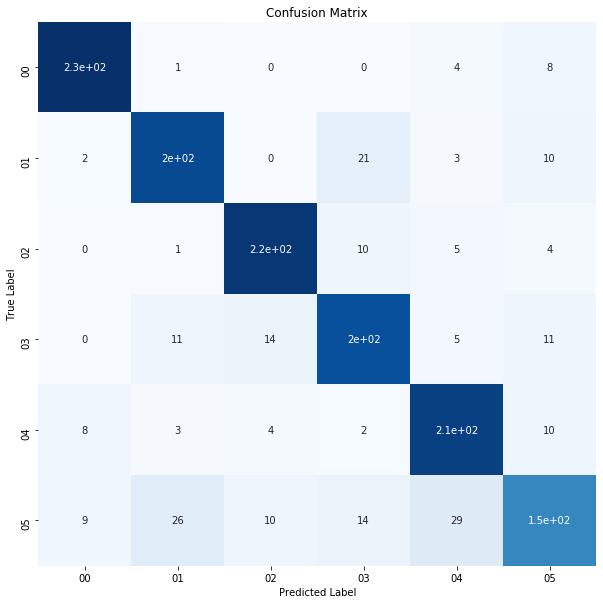

In [116]:
import seaborn as sns

matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, annot=True, cbar=False, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

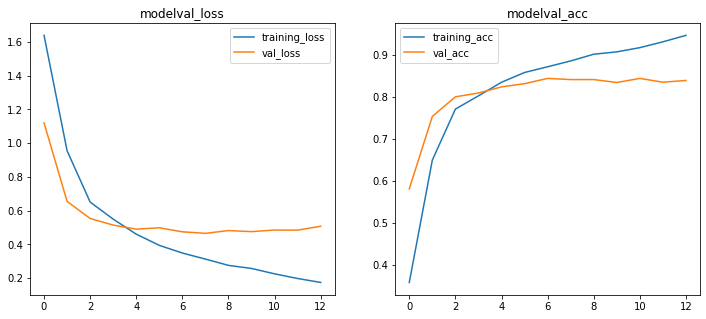

In [117]:
train_history = ['loss', 'val_loss', 'accuracy', 'val_accuracy']
name_history = ['training_loss', 'val_loss', 'training_acc', 'val_acc']

plt.figure(figsize=(12, 5))
for eachx, eachy, i in zip(train_history, name_history, range(4)):
    if i % 2 == 0:
        plt.subplot(1, 2, i//2+1)
    l_x = len(history.history[eachx])
    plt.plot(np.arange(l_x), history.history[eachx], label=eachy)
    plt.legend(loc='best')
    plt.title('model'+eachy)
plt.show()

In [118]:
test_generator.reset()

In [119]:
test_pred = model.predict_generator(test_generator)

In [120]:
test_pred = test_pred.argmax(-1)

In [121]:
filenames = test_generator.filenames

In [122]:
result = pd.DataFrame({'fileName':last_test2,'class': test_pred})
result

,fileName,class
0,1e4684066c27459a.png,2
1,02bcf014ef364575.png,0
2,7bcc1a419ac1455f.png,4
3,2126e910a9fb49bf.png,0
4,0b3fd069c1dd4558.png,3
...,...,...
2995,61b061bd22074c46.png,4
2996,01c6177c484f4c9a.png,2
2997,4a8e3f57b3e7405b.png,4
2998,0c16d7e602254958.png,3


In [123]:
result.to_csv('cw-hair-0727-1302.csv',index=False)